# Imports

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import statsmodels.api as sm
from patsy.highlevel import dmatrix
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from tqdm import trange
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, HMCGibbs
from numpyro.infer.initialization import init_to_value
from shared.config_plt import config_plt, get_fig_ax, save_my_fig, colors
from shared.utils import float2str_format, print_se_parentheses
config_plt()

# Preprocessing

In [2]:
# The data can be downloaded from https://osf.io/ajcr6/
df = pd.read_excel("./data_set_fast_food_study_OSF.xlsx")
df.head()

,participant,Highest educational level binary,Level of education composite,availability,labelling,Total meal energy,Fast food frequency,Healthiness motivation score,Weight control motivation score,Interference stroop effect,Proportion of correct responses in incongruent trials,Two-error maximum lenght,Maximun lenght,Self-control score,study
0,1,High,0.859923,1,1,707,Never or not in the last year,3,3,337.0,0.857143,4,4,52,1
1,2,Low,-1.093325,1,0,726,1-3 times per month,6,5,474.0,0.857143,6,8,41,1
2,3,High,-0.211802,1,0,847,1-3 times per month,5,5,460.5,0.821429,8,8,31,1
3,4,Low,-0.462362,1,0,705,Less than once per month,5,3,329.0,0.964286,10,10,44,1
4,5,High,0.799564,1,0,1137,1-2 times per week,6,4,401.0,0.821429,6,7,39,1


In [3]:
# Numeric codes for categorical variables
df["Fast food frequency (numeric)"] = df["Fast food frequency"].replace({
    "Never or not in the last year": "0",
    "Less than once per month": "1",
    "1-3 times per month": "2",
    "1-2 times per week": "3",
    "3 times per week or more": "4"
}).astype(float)

df["Fast food weekly"] = df["Fast food frequency"].replace({
    "Never or not in the last year": "False",
    "Less than once per month": "False",
    "1-3 times per month": "False",
    "1-2 times per week": "True",
    "3 times per week or more": "True"
}) == "True"

df["Highest educational level binary (numeric)"] = df["Highest educational level binary"].replace({
    "High": "True",
    "Low": "False",
}) == "True"

In [4]:
# Variables for column names
treatment_column = "availability"
outcome_column = "Total meal energy"
covariate_columns = [
    "Highest educational level binary (numeric)",
    "Level of education composite",
    "Fast food frequency (numeric)",
    "Fast food weekly",
    "Healthiness motivation score",
    "Weight control motivation score",
    "Interference stroop effect",
    "Two-error maximum lenght",
    "Maximun lenght",  # Original (mis)spelling in the data
    "Self-control score"]
num_covariates = len(covariate_columns)

In [5]:
# Store data as variables for easy use
y = df[outcome_column]
n = y.size
a = df[treatment_column]
a_logical = a.astype(bool)
idx1 = np.arange(n)[a_logical]
idx0 = np.arange(n)[~a_logical]
n0 = idx0.size
n1 = idx1.size
p = 0.5
alpha = 0.05
z_star = float(norm.ppf(1.-alpha/2.))

# ATE Estimate

In [6]:
# 2-sample z-test
y1 = y[idx1]
y0 = y[idx0]
dim_estimate = y1.mean() - y0.mean()
se = np.sqrt(y1.var(ddof=0)/y1.size + y0.var(ddof=0)/y0.size)
ci = dim_estimate + z_star * np.array([-1, 1]) * se
dim_estimate_ci = float2str_format(dim_estimate) + " (" + " ".join(float2str_format(ci)) + ")"
print(dim_estimate_ci)

-71.088 (-92.269 -49.907)


In [7]:
# The 2-sample z-test exactly matches a linear model estimate with robust standard errors
X = np.ones((n, 2))
X[:, 1] = a
X_df = pd.DataFrame(data=X, columns=["Intercept", treatment_column])
mod_ate = sm.OLS(y, X_df).fit(cov_type="HC0")
mod_results = mod_ate.conf_int()
mod_results.columns = ["Lower", "Upper"]
mod_results.insert(0, "Estimate", mod_ate.params)
mod_results = mod_results.apply(float2str_format)
mod_results.loc[treatment_column]

Estimate    -71.088
Lower       -92.269
Upper       -49.907
Name: availability, dtype: object

# Fisherian Randomization Test (FRT)

In [8]:
# H0: No effect for any unit
a_samples = np.random.random((10000, n)) > 0.5
dim = np.sum(a*y) / np.sum(a) - np.sum((1-a)*y) / np.sum(1-a)
dim_samples = (
    np.sum(a_samples*y.values, axis=1) / np.sum(a_samples, axis=1) -
    np.sum((1-a_samples)*y.values, axis=1) / np.sum(1-a_samples, axis=1)
)

./figures/case-study/fast-food-frt


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


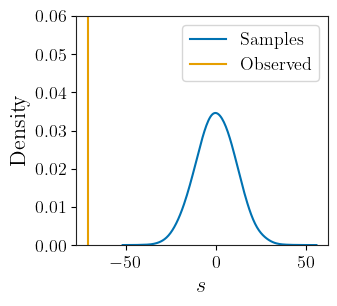

In [9]:
figsize = (3.4, 2.9)
left_adjust = 0.23
bottom_adjust = 0.18
right_adjust = 0.97
top_adjust = 0.97
fig, ax = get_fig_ax(figsize=figsize)
sns.kdeplot(x=dim_samples, ax=ax, bw_adjust=2., color=colors[0], label="Samples")
ax.axvline(dim, label="Observed", color=colors[1])
ax.legend()
ax.set_xlabel("$s$")
ax.set_ylabel("Density")
ax.set_ylim(0, 0.06)
fig.tight_layout()
plt.subplots_adjust(left_adjust, bottom_adjust, right_adjust, top_adjust)
save_my_fig(fig, "case-study/fast-food-frt")

In [10]:
frt_p_value = np.mean(np.abs(dim_samples) > np.abs(dim))
print(f"The p-value from the FRT is {frt_p_value}")

The p-value from the FRT is 0.0


# BRI Analysis

## Constant treatment-effect model

In [11]:
# Helper functions for computing moments
def get_moments(y, a_logical):
    idx1 = np.arange(n)[a_logical]
    idx0 = np.arange(n)[~a_logical]
    y0 = y[idx0]
    y1 = y[idx1]
    m0 = jnp.mean(y0)
    m1 = jnp.mean(y1)
    v0 = jnp.var(y0, ddof=1)
    v1 = jnp.var(y1, ddof=1)
    return m0, m1, v0, v1

def get_moment_samples(y0, y1, a_samples):
    n0_samples = jnp.sum(1-a_samples, axis=1)
    n1_samples = jnp.sum(a_samples, axis=1)
    sum0_samples = jnp.sum(y0*(1-a_samples), axis=1)
    sum1_samples = jnp.sum(y1*a_samples, axis=1)
    m0 = sum0_samples / n0_samples
    m1 = sum1_samples / n1_samples
    sumsq0_samples = jnp.sum((y0**2)*(1-a_samples), axis=1)
    sumsq1_samples = jnp.sum((y1**2)*a_samples, axis=1)
    meansq0 = sumsq0_samples / n0_samples
    meansq1 = sumsq1_samples / n1_samples
    v0 = (meansq0 - m0**2) * n0_samples / (n0_samples - 1.)
    v1 = (meansq1 - m1**2) * n1_samples / (n1_samples - 1.)
    return m0, m1, v0, v1

In [12]:
m0, m1, v0, v1 = get_moments(y.values, a_logical)
s_observed = m1 - m0
var_ratio = jnp.maximum(v1, v0) / jnp.minimum(v1, v0)

In [13]:
# NumPyro model function
def constant_effect_model(num_a_samples=None):
    # Prior
    theta = numpyro.sample("theta", dist.Normal(0., 100.))
    
    # Observed statistic
    y0_imputed = y.values - a.values * theta
    y1_imputed = y0_imputed + theta
    
    # Samples
    if num_a_samples is None:
        likelihood_mean = theta
        ybar = y.values.mean()
        likelihood_var = ((2*y.values + (1. - 2.*a.values)*theta - 2*ybar + (n1-n0)/n*theta)**2).mean()/n
        likelihood_std = jnp.sqrt(likelihood_var)
    else:
        # NOTE: These samples are not redrawn within the MCMC algorithm
        a_samples = dist.Bernoulli(0.5).sample(numpyro.prng_key(), (num_a_samples, n))
        m0_s, m1_s, v0_s, v1_s = get_moment_samples(y0_imputed, y1_imputed, a_samples)
        s_samples = m1_s - m0_s
        var_ratio_samples = jnp.maximum(v1_s, v0_s) / jnp.minimum(v1_s, v0_s)
        var_ratio_pval = jnp.mean(var_ratio_samples > var_ratio)
        numpyro.deterministic("var_ratio_samples", var_ratio_samples)
        numpyro.deterministic("var_ratio_pval", var_ratio_pval)
        likelihood_mean = s_samples.mean()
        likelihood_std = s_samples.std(ddof=1)
        
    parametric_log_estimate = -0.5 * ((s_observed - likelihood_mean)/likelihood_std)**2 - jnp.log(likelihood_std)
    numpyro.factor("s_density", parametric_log_estimate)

rng_key = random.PRNGKey(0)
constant_effect_kernel = NUTS(constant_effect_model)

In [14]:
# Asymptotic variance: fast
constant_effect_asymptotic_mcmc = MCMC(constant_effect_kernel, num_warmup=2000, num_samples=10000)
constant_effect_asymptotic_mcmc.run(rng_key, num_a_samples=None)
constant_effect_asymptotic_mcmc.print_summary(prob=0.95)

sample: 100%|████████████████| 12000/12000 [00:01<00:00, 6033.39it/s, 3 steps of size 1.05e+00. acc. prob=0.92]



                mean       std    median      2.5%     97.5%     n_eff     r_hat
     theta    -70.09     10.72    -70.16    -90.25    -48.38   3269.26      1.00

Number of divergences: 0


./figures/case-study/constant-posterior


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


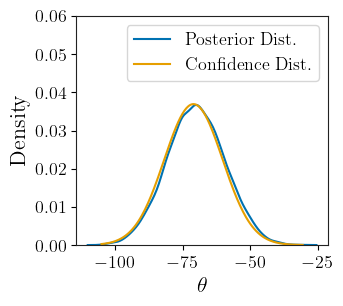

In [15]:
fig, ax = get_fig_ax(figsize=figsize)
theta_samples = constant_effect_asymptotic_mcmc.get_samples()["theta"]
sns.kdeplot(x=theta_samples, ax=ax, bw_adjust=1., color=colors[0], label="Posterior Dist.")
theta_vals = np.linspace(theta_samples.min(), theta_samples.max(), 200)
ci_pdf = norm.pdf(theta_vals, loc=dim_estimate, scale=se)
ax.plot(theta_vals, ci_pdf, color=colors[1], label="Confidence Dist.")
ax.legend()  # Lines are too wide by default
ax.set_ylim(0, 0.06)
ax.set_xlabel("$\\theta$")
plt.subplots_adjust(left_adjust, bottom_adjust, right_adjust, top_adjust)
save_my_fig(fig, "case-study/constant-posterior")

In [16]:
df_moderators = df.loc[:, covariate_columns]
X_moderators = df_moderators.values.astype(float)

def get_coefs(y, X):
    n = y.size
    y_c = y - y.mean()
    X_c = X - X.mean(axis=0)
    Xy_covs = (X_c.T @ y_c) / n
    X_vars = (X_c**2).sum(axis=0) / n
    coefs = Xy_covs / X_vars
    return coefs

def get_coef_diffs(y, a_logical):
    idx1 = np.arange(n)[a_logical]
    idx0 = np.arange(n)[~a_logical]
    coefs1 = get_coefs(y[idx1], X_moderators[idx1])
    coefs0 = get_coefs(y[idx0], X_moderators[idx0])
    coef_diffs = coefs1 - coefs0
    return coef_diffs

coef_diffs = get_coef_diffs(y.values, a_logical)
abs_coef_diffs = np.abs(coef_diffs)

In [21]:
thetas = theta_samples
n_samples = thetas.size
y_mat = np.zeros((n_samples, n))
y_mat[:] = y.values
a_mat = np.zeros((n_samples, n))
a_mat[:] = a.values
y0_samples = y_mat - (a_mat.T * thetas).T
y1_samples = (y0_samples.T + thetas).T
var_ratio_samples = np.zeros(n_samples)
abs_coef_diffs_samples = np.zeros((n_samples, X_moderators.shape[1]))
for i in trange(n_samples):
    a_sample = np.random.random(n) < 0.5
    y0_sample = y0_samples[i]
    y1_sample = y1_samples[i]
    y_sample = a_sample*y1_sample + (~a_sample)*y0_sample
    m0, m1, v0, v1 = get_moments(y_sample, a_sample)
    var_ratio_samples[i] = jnp.maximum(v1, v0) / jnp.minimum(v1, v0)
    coef_diffs_sample = get_coef_diffs(y_sample, a_sample)
    abs_coef_diffs_samples[i] = np.abs(coef_diffs_sample)
p_value_var_ratio = np.mean(var_ratio_samples > var_ratio)
print(f"p-value for variance ratio: {p_value_var_ratio}")
p_values_moderation = np.mean(abs_coef_diffs_samples > abs_coef_diffs, axis=0)
print(f"p-values for moderation: {p_values_moderation}")

100%|███████████████████████████████████████████████████████████████████| 10000/10000 [00:13<00:00, 741.47it/s]

p-value for variance ratio: 0.0
p-values for moderation: [0.7762 0.3041 0.0889 0.9939 0.2899 0.5115 0.5822 0.6883 0.4712 0.1225]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


./figures/case-study/variance-ratio


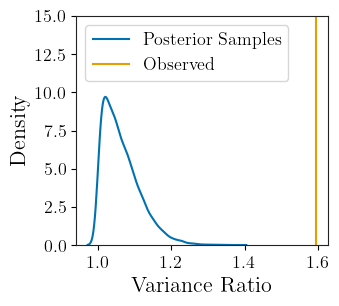

In [22]:
fig, ax = get_fig_ax(figsize=figsize)
sns.kdeplot(
    x=var_ratio_samples,
    ax=ax, bw_adjust=1.2, color=colors[0], label="Posterior Samples")
ax.axvline(var_ratio, color=colors[1], label="Observed")
ax.set_xlabel("Variance Ratio")
ax.set_ylim(0, 15)
ax.legend()
plt.subplots_adjust(left_adjust, bottom_adjust, right_adjust, top_adjust)
save_my_fig(fig, "case-study/variance-ratio")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


./figures/case-study/data-kde


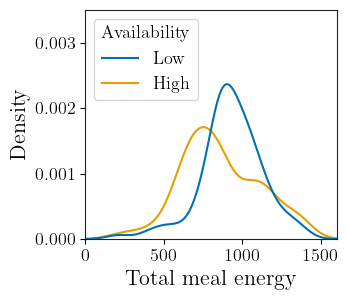

In [23]:
def make_kde_plot(kde_df, filepath, legend=False):
    fig, ax = get_fig_ax(figsize=figsize)
    bw_adjust = 1.4
    sns.kdeplot(data=kde_df, x="Total meal energy", hue="Availability", ax=ax, bw_adjust=bw_adjust, legend=legend, common_norm=False, common_grid=True)
    if legend:
        sns.move_legend(ax, "upper left")
    ax.set_xlim(0, 1600)
    ax.set_ylim(0, 0.0035)
    y_ticks = [0.000, 0.001, 0.002, 0.003]
    ax.set_yticks(y_ticks)
    plt.subplots_adjust(left_adjust, bottom_adjust, right_adjust, top_adjust)
    save_my_fig(fig, filepath)
    plt.show()

df["Availability"] = df["availability"].replace({0: "Low", 1: "High"})
make_kde_plot(df.sort_values(by="Availability", ascending=False), "case-study/data-kde", legend=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


./figures/case-study/constant-kde


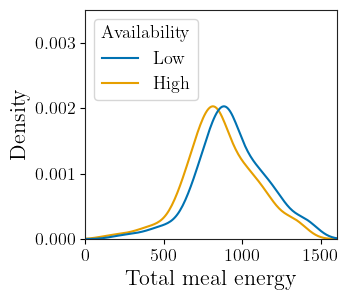

In [24]:
theta_pm = theta_samples.mean()
y0_imputed_constant = y.values - a.values * theta_pm
y1_imputed_constant = y0_imputed_constant + theta_pm
df_imputed_constant = pd.DataFrame({
    "Total meal energy": np.concatenate([y0_imputed_constant, y1_imputed_constant]),
    "Availability": ["Low"]*n + ["High"]*n,
})
make_kde_plot(df_imputed_constant, "case-study/constant-kde", legend=True)

In [25]:
# Estimate variance via Monte Carlo: slow
# The results are very similar to the asymptotic approximation
# This approach could also be adapted to sample a within each iteration
# See the models below for examples of how to do this
constant_effect_mcmc = MCMC(constant_effect_kernel, num_warmup=1000, num_samples=1000)
constant_effect_mcmc.run(rng_key, num_a_samples=1000)
constant_effect_mcmc.print_summary(prob=0.95)

sample: 100%|████████████████████| 2000/2000 [00:32<00:00, 61.71it/s, 3 steps of size 9.57e-01. acc. prob=0.93]



                mean       std    median      2.5%     97.5%     n_eff     r_hat
     theta    -70.29     10.51    -70.20    -89.55    -48.11    386.01      1.00

Number of divergences: 0


## Stochastic shift-scale model

In [26]:
def jnp_kth_root(x, k):
    signs = jnp.sign(x)
    return signs * jnp.abs(x)**(1./k)

def get_5_moments(b, a_logical):
    idx1 = np.arange(n)[a_logical]
    b1 = b[idx1]
    m1 = jnp.mean(b1)
    v1 = jnp.var(b1)
    sd1 = jnp.sqrt(v1)
    z1 = (b1 - m1) / sd1
    s1 = jnp_kth_root(jnp.mean(z1**3), 3)
    k1 = jnp_kth_root(jnp.mean(z1**4), 4)
    f1 = jnp_kth_root(jnp.mean(z1**5), 5)
    moments = jnp.array([m1, sd1, s1, k1, f1])
    return moments

def get_5_moment_samples(b, a_samples):
    n1_samples = jnp.sum(a_samples, axis=1)
    sum1_samples = jnp.sum(b*a_samples, axis=1)
    m1 = sum1_samples / n1_samples
    sumsq1_samples = jnp.sum((b**2)*a_samples, axis=1)
    meansq1 = sumsq1_samples / n1_samples
    v1 = meansq1 - m1**2
    sd1 = jnp.sqrt(v1)
    z1 = ((b.T - m1) / sd1).T
    s1 = jnp_kth_root(jnp.sum((z1**3)*a_samples, axis=1) / n1_samples, 3)
    k1 = jnp_kth_root(jnp.sum((z1**4)*a_samples, axis=1) / n1_samples, 4)
    f1 = jnp_kth_root(jnp.sum((z1**5)*a_samples, axis=1) / n1_samples, 5)
    moments = jnp.vstack([m1, sd1, s1, k1, f1])
    return moments

five_moments = get_5_moments(y.values, a_logical)

In [27]:
def random_shift_scale_model(num_a_samples=1000):
    # Prior
    alpha = numpyro.sample("alpha", dist.Normal(0., 1000.))
    beta = numpyro.sample("beta", dist.Gamma(1., 1.))
    sigma = numpyro.sample("sigma", dist.HalfNormal(100.))
    with numpyro.plate_stack("epsilon_plate_stack", [num_a_samples, n]):
        a_samples = numpyro.sample("a_samples", dist.Bernoulli(0.5))
        epsilon = numpyro.sample("epsilon", dist.Normal())
    y1_imputed = a.values*y.values + (1.-a.values)*(alpha + beta*y.values + sigma*epsilon)
    s_observed = five_moments[:2]
        
    # Samples
    five_moments_samples = get_5_moment_samples(y1_imputed, a_samples)
    s_samples = five_moments_samples[:2]
    likelihood_mean = s_samples.mean(axis=1)
    likelihood_cov = jnp.cov(s_samples)
    
    # Model checking
    props = (five_moments_samples.T <= five_moments).mean(axis=0)
    ps = 2 * (0.5 - jnp.abs(props - 0.5))
    numpyro.deterministic("ps", ps)
    y1_imputed_single = y1_imputed[0]
    numpyro.deterministic("y1_imputed", y1_imputed_single)
        
    # Likelihood
    d = s_observed - likelihood_mean
    maha = d @ jnp.linalg.solve(likelihood_cov, d)
    parametric_log_estimate = -0.5 * (maha + jnp.linalg.slogdet(likelihood_cov)[1])
    numpyro.factor("s_density", parametric_log_estimate)
    

def random_shift_scale_gibbs(rng_key, gibbs_sites, hmc_sites):
    new_a_samples = dist.Bernoulli(0.5).sample(rng_key, gibbs_sites["a_samples"].shape)
    new_epsilon = dist.Normal().sample(rng_key, gibbs_sites["epsilon"].shape)
    return {"a_samples": new_a_samples, "epsilon": new_epsilon}


random_shift_scale_hmc_kernel = NUTS(random_shift_scale_model, dense_mass=[("alpha", "beta", "sigma")], step_size=0.1, max_tree_depth=7)
random_shift_scale_kernel = HMCGibbs(random_shift_scale_hmc_kernel, gibbs_fn=random_shift_scale_gibbs, gibbs_sites=["a_samples", "epsilon"])
random_shift_scale_mcmc = MCMC(random_shift_scale_kernel, num_warmup=2000, num_samples=10000, progress_bar=True)
random_shift_scale_mcmc.run(random.PRNGKey(0), num_a_samples=100, extra_fields=("~z.a_samples", "~z.epsilon",))
random_shift_scale_mcmc.print_summary() 

sample: 100%|█████████████████| 12000/12000 [02:15<00:00, 88.79it/s, 23 steps of size 1.64e-01. acc. prob=0.87]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha   -210.28    103.96   -228.16   -363.36    -27.73    949.90      1.01
      beta      1.22      0.07      1.23      1.11      1.34   1400.55      1.00
     sigma     84.93     59.39     75.34      0.00    172.53    782.50      1.01



./figures/case-study/shift-scale-p-values


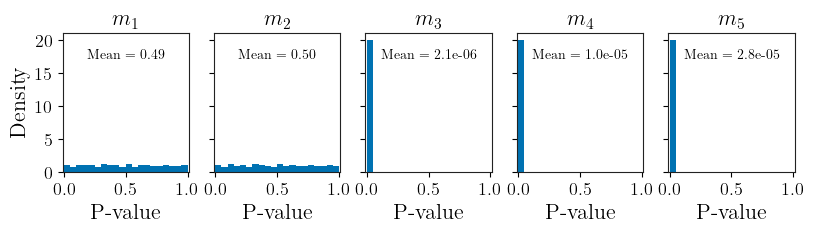

In [28]:
def make_p_plots(ps, filename):
    fig, axs = plt.subplots(1, 5, figsize=(8, 2.1))
    for i in range(5):
        ax_i = axs[i]
        ax_i.hist(ps[:, i], bins=np.arange(0., 1.001, 0.05), density=True)
        ax_i.set_xlim(-0.01, 1.01)
        ax_i.set_ylim(0, 21)
        ax_i.set_xticks(np.arange(0., 1.001, 0.5))
        ax_i.set_title(f"$m_{i+1}$")
        post_mean_pvalue = ps[:, i].mean()
        if post_mean_pvalue > 0.01:
            post_mean_pvalue_text = f"{post_mean_pvalue:.2f}"
        else:
            post_mean_pvalue_text = f"{post_mean_pvalue:.1e}"
        ax_i.text(0.5, 17, "Mean = " + post_mean_pvalue_text, horizontalalignment="center")
        ax_i.set_xlabel("P-value")
        yticks = np.arange(0., 20.1, 5.)
        if i:
            ax_i.set_yticks(yticks, labels=[""]*yticks.size)
        else:
            ax_i.set_yticks(np.arange(0., 20.1, 5.))
            ax_i.set_ylabel("Density")
    plt.subplots_adjust(0.07, 0.24, 0.985, 0.9)
    save_my_fig(fig, filename)

make_p_plots(random_shift_scale_mcmc.get_samples()["ps"], "case-study/shift-scale-p-values")

./figures/case-study/shift-scale-y1


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


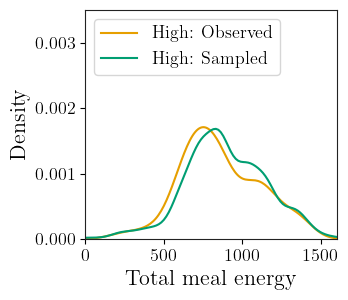

In [29]:
def plot_y1_imputations(y1_imputed, filename, bw_adjust=5):
    fig, ax = get_fig_ax(figsize=figsize)
    sns.kdeplot(y1, ax=ax, bw_adjust=1.4, color=colors[1], label="High: Observed")
    sns.kdeplot(y1_imputed[::10, :].flatten(), ax=ax, bw_adjust=bw_adjust, color=colors[2], label="High: Sampled")
    ax.set_xlim(0, 1600)
    ax.set_ylim(0, 0.0035)
    y_ticks = [0.000, 0.001, 0.002, 0.003]
    ax.set_yticks(y_ticks)
    ax.legend(loc="upper left")
    plt.subplots_adjust(left_adjust, bottom_adjust, right_adjust, top_adjust)
    save_my_fig(fig, filename)
    plt.show()
    
plot_y1_imputations(random_shift_scale_mcmc.get_samples()["y1_imputed"], "case-study/shift-scale-y1", bw_adjust=4)

## Spline model

In [30]:
y_mean = y.values.mean()
y_sd = y.values.std()
calorie_vals = np.arange(y.max()*2 + 1) / 2.
calorie_vals_std = (calorie_vals - y_mean) / y_sd
calorie_vals_std_whole = calorie_vals_std[::2]
calorie_vals_std2 = calorie_vals_std**2
calorie_vals_std3 = calorie_vals_std**3

def increasing_model(y1_mat):
    # Prior
    num_a_samples = y1_mat.shape[0]
    theta = numpyro.sample("theta", dist.Normal(-4., 2.))
    beta0 = numpyro.sample("beta0", dist.Normal(-5.5, 1.))
    beta1 = numpyro.sample("beta1", dist.Normal(0., 0.5))
    beta2 = numpyro.sample("beta2", dist.Normal(0., 0.2))
    beta3 = numpyro.sample("beta3", dist.Normal(0., 0.1))
    sigma = numpyro.sample("sigma", dist.HalfNormal(100.))
    with numpyro.plate_stack("a_samples_plate_stack", [num_a_samples, n]):
        a_samples = numpyro.sample("a_samples", dist.Bernoulli(0.5))
    with numpyro.plate_stack("epsilon_plate_stack", [num_a_samples, n0]):
        epsilon = numpyro.sample("epsilon", dist.Normal())
    
    # Causal effects
    g = jnp.exp(
        beta0 +
        beta1 * calorie_vals_std +
        beta2 * calorie_vals_std2 +
        beta3 * calorie_vals_std3)
    incremental_causal_effects = (g[:-2:2] + 4 * g[1:-1:2] + g[2::2]) / 6.  # Simpson's rule
    causal_effects_raw = jnp.concatenate([jnp.array([0.]), np.cumsum(incremental_causal_effects)])
    causal_effects = y_sd*(theta + causal_effects_raw) + y_mean
    numpyro.deterministic("causal_effects", causal_effects)
    s_observed = five_moments  # all 5 moments
    
    # Sampled statistic values
    y1_imputed_0s = causal_effects[y0.values] + sigma*epsilon
    y1_imputed = jnp.hstack([y1_imputed_0s, y1_mat])  # Order doesn't matter b/c randomization is simple
    s_samples = get_5_moment_samples(y1_imputed, a_samples)
    likelihood_mean = s_samples.mean(axis=1)
    likelihood_cov = jnp.cov(s_samples)
    
    # Model checking
    props = (s_samples.T <= s_observed).mean(axis=0)
    ps = 2 * (0.5 - jnp.abs(props - 0.5))
    numpyro.deterministic("ps", ps)
    y1_imputed_single = y1_imputed[0]
    numpyro.deterministic("y1_imputed", y1_imputed_single)
        
    # Likelihood
    d = s_observed - likelihood_mean
    maha = d @ jnp.linalg.solve(likelihood_cov, d)
    parametric_log_estimate = -0.5 * (maha + jnp.linalg.slogdet(likelihood_cov)[1])
    numpyro.factor("s_density", parametric_log_estimate)
    

def increasing_gibbs(rng_key, gibbs_sites, hmc_sites):
    new_a_samples = dist.Bernoulli(0.5).sample(rng_key, gibbs_sites["a_samples"].shape)
    new_epsilon = dist.Normal().sample(rng_key, gibbs_sites["epsilon"].shape)
    return {"a_samples": new_a_samples, "epsilon": new_epsilon}

init_params = {
    "theta": calorie_vals_std.min(),
    "beta0": -5.5,
    "beta1": 0.,
    "beta2": 0.,
    "beta3": 0.,
    "sigma": 100.
}
increasing_hmc_kernel = NUTS(increasing_model, dense_mass=[("theta", "beta0", "beta1", "beta2", "beta3", "sigma")], init_strategy=init_to_value(values=init_params))
increasing_kernel = HMCGibbs(increasing_hmc_kernel, gibbs_fn=random_shift_scale_gibbs, gibbs_sites=["a_samples", "epsilon"])
increasing_mcmc = MCMC(increasing_kernel, num_warmup=20000, num_samples=20000, progress_bar=True, thinning=10)
y1_mat = np.zeros((1000, n1))
y1_mat[:] = y1.values
increasing_mcmc.run(random.PRNGKey(0), y1_mat=y1_mat, extra_fields=("~z.a_samples", "~z.epsilon",))
increasing_mcmc.print_summary() 

sample: 100%|█████████████| 40000/40000 [19:45:52<00:00,  1.78s/it, 127 steps of size 2.36e-02. acc. prob=0.72]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0     -5.39      0.53     -5.16     -6.18     -4.89    710.61      1.00
     beta1      0.27      0.23      0.29     -0.08      0.61    800.71      1.00
     beta2     -0.23      0.14     -0.25     -0.45     -0.01   1453.80      1.00
     beta3     -0.00      0.07     -0.01     -0.11      0.10    661.43      1.00
     sigma    121.58     71.78    118.12     13.85    235.10    619.79      1.00
     theta     -2.29      0.76     -2.30     -3.60     -0.89    310.48      1.00



./figures/case-study/increasing-p-values


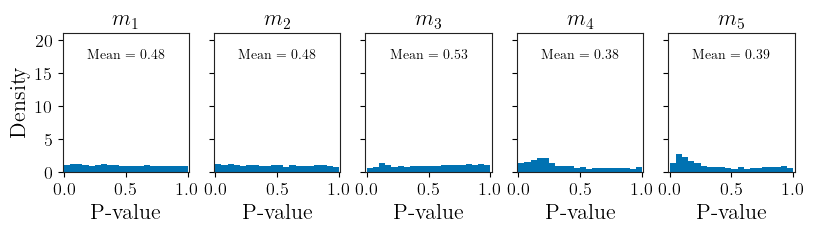

In [31]:
make_p_plots(increasing_mcmc.get_samples()["ps"], "case-study/increasing-p-values")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


./figures/case-study/increasing-y1


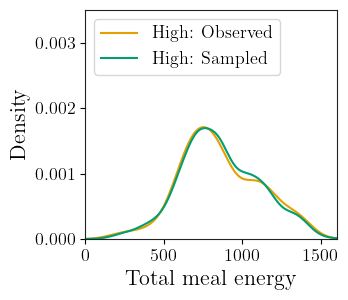

In [32]:
plot_y1_imputations(increasing_mcmc.get_samples()["y1_imputed"], "case-study/increasing-y1", bw_adjust=3.5)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


./figures/case-study/calorie-mean-plot


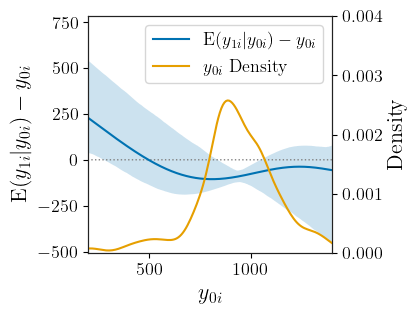

In [47]:
calorie_vals_whole = calorie_vals[::2]
causal_effect_samples = increasing_mcmc.get_samples()["causal_effects"] - calorie_vals_whole
causal_effect_pm = causal_effect_samples.mean(axis=0)
causal_effect_lower = np.percentile(causal_effect_samples, 2.5, axis=0)
causal_effect_upper = np.percentile(causal_effect_samples, 97.5, axis=0)
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(
    calorie_vals_whole,
    np.zeros_like(calorie_vals_whole),
    color="gray",
    lw=1,
    linestyle=":"
)
ax.fill_between(
    calorie_vals_whole,
    causal_effect_lower,
    causal_effect_upper,
    alpha=0.2
)
first_idx = 0
ax.plot(calorie_vals[::2][(first_idx+4):-4], causal_effect_pm[(first_idx+4):-4])
ax.set_xlabel("$y_{0i}$")
ax.set_ylabel("E$(y_{1i} | y_{0i}) - y_{0i}$")
ax_twin = ax.twinx()
sns.kdeplot(y0, ax=ax_twin, color=colors[1])
ax_twin.set_xlim(y0.min(), y0.max())
# ax_twin.set_xlim(calorie_vals_whole.min(), calorie_vals_whole.max())
ax_twin.set_ylim(0, 0.004)
ax_twin.set_yticks([0., 0.001, 0.002, 0.003, 0.004])
blue_line = Line2D([0], [0], label="E$(y_{1i} | y_{0i}) - y_{0i}$", color=colors[0])
orange_line = Line2D([0], [0], label="$y_{0i}$ Density", color=colors[1])
ax.legend(handles=[blue_line, orange_line])
plt.subplots_adjust(0.2, 0.18, 0.81, 0.97)
save_my_fig(fig, "case-study/calorie-mean-plot")

./figures/case-study/calorie-dist-plot


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


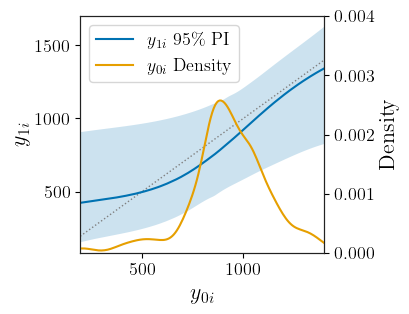

In [44]:
y1_imputed_increasing = increasing_mcmc.get_samples()["y1_imputed"][:, :n0]
y0_arg_sort = np.argsort(y0).tolist()
y0_sorted = y0.values[y0_arg_sort]
y1_imputed_increasing = y1_imputed_increasing[:, y0_arg_sort]
y1_imputed_increasing_pm = y1_imputed_increasing.mean(axis=0)
y1_imputed_increasing_lower = np.percentile(y1_imputed_increasing, 2.5, axis=0)
y1_imputed_increasing_upper = np.percentile(y1_imputed_increasing, 97.5, axis=0)
def smooth_y0(x):
    X_smoothing = dmatrix("bs(x, df=12, degree=3)", {"x": y0_sorted})
    mod = sm.OLS(np.asarray(x), np.asarray(X_smoothing)).fit()
    return mod.fittedvalues

fig, ax = get_fig_ax(figsize=(4,3))
ax.plot(y0_sorted, y0_sorted, color="gray", lw=1, linestyle=":")
ax.fill_between(y0_sorted, smooth_y0(y1_imputed_increasing_lower), smooth_y0(y1_imputed_increasing_upper), alpha=0.2)
ax.plot(y0_sorted, smooth_y0(y1_imputed_increasing_pm))
ax.set_xlabel("$y_{0i}$")
ax.set_ylabel("$y_{1i}$")
ax_twin = ax.twinx()
sns.kdeplot(y0, ax=ax_twin, color=colors[1])
ax_twin.set_xlim(y0.min(), y0.max())
ax_twin.set_ylim(0, 0.004)
ax_twin.set_yticks([0., 0.001, 0.002, 0.003, 0.004])
blue_line = Line2D([0], [0], label="$y_{1i}$ 95\\% PI", color=colors[0])
orange_line = Line2D([0], [0], label="$y_{0i}$ Density", color=colors[1])
ax.legend(handles=[blue_line, orange_line])
plt.subplots_adjust(0.2, 0.18, 0.81, 0.97)
save_my_fig(fig, "case-study/calorie-dist-plot")

In [49]:
np.sum(y0 <= 274)

np.int64(10)